In [2]:
## Imports

import requests
import pandas as pd
from pathlib import Path
import json
from datetime import datetime
import numpy as np
import concurrent.futures
import os
from matplotlib import pyplot as plt
import seaborn as sns
import shutil

In [3]:
## Define functions and classes here

def quick_convert(json_data,name):
    params = json_data['properties']['parameter']
    all_dates = set()
    for param_data in params.values():
        all_dates.update(param_data.keys())
    dates = sorted(list(all_dates))
    
    df = pd.DataFrame([{
        'date': datetime.strptime(d, '%Y%m%d').strftime('%Y-%m-%d'),
        **{var: params[var][d] for var in params.keys()}
    } for d in dates])
    
    df.to_csv(f'{name}.csv', index=False)
    return df

def quick_convert_coordinate(json_data,name):
    coords = json_data['geometry']['coordinates']
    params = json_data['properties']['parameter']
    all_dates = set()
    for param_data in params.values():
        all_dates.update(param_data.keys())
    dates = sorted(list(all_dates))
    
    df = pd.DataFrame([{
        'date': datetime.strptime(d, '%Y%m%d').strftime('%Y-%m-%d'),
        'latitude': coords[1],
        'longitude': coords[0],
        'elevation': coords[2] if len(coords) > 2 else None,
        #'wkt_geometry': f"POINT ({coords[0]} {coords[1]})",
        **{var: params[var].get(d, None) for var in params.keys()}  # Use .get() for missing dates
    } for d in dates])
    
    df.to_csv(f'{name}.csv', index=False)
    return df

url = "https://power.larc.nasa.gov/api/temporal/daily/point"

headers = {
    "accept": "application/json"
}

def prompt(start, end, lan, lon):
    params = {
        "start": start,
        "end": end,
        "latitude": lan,
        "longitude": lon,
        "community": "ag",
        "parameters": "T2M,T2M_MIN,T2M_MAX,T2MDEW,PRECTOTCORR,RH2M,QV2M,WS10M,ALLSKY_SFC_SW_DWN,ALLSKY_SFC_LW_DWN",
        "format": "json",
        "units": "metric",
        "user": "K231",
        "header": "true"
    }
    response = requests.get(url, params=params, headers=headers)
    data = response.json()
    return quick_convert_coordinate(data, "nasapastdatacoordinateadvpara")

data=pd.read_csv("all_locations_data_3.csv")
data_daily=pd.read_csv("all_locations_data_3.csv")
data_cleaning=data.drop(["date","latitude","longitude","elevation"],axis=1)
#data_cleaning['datetime'] = pd.to_datetime(data['datetime'])
#data_cleaning=data_cleaning.drop(["IMERG_PRECLIQUID_PROB","latitude","longitude","elevation"],axis=1)
# Extract numeric features
#data_cleaning['year'] = data_cleaning['datetime'].dt.year
#data_cleaning['month'] = data_cleaning['datetime'].dt.month
#data_cleaning['day'] = data_cleaning['datetime'].dt.day
#data_cleaning['hour'] = data_cleaning['datetime'].dt.hour
#data_cleaning['minute'] = data_cleaning['datetime'].dt.minute
#data_cleaning['day_of_week'] = data_cleaning['datetime'].dt.dayofweek  # 0=Monday, 6=Sunday

## Optional: Convert to Unix timestamp (seconds since 1970-01-01)
#data_cleaning['unix_timestamp'] = data_cleaning['date'].astype(int) // 10**9
#
## Optional: Time differences (e.g., seconds since first timestamp)
#data_cleaning['time_diff'] = (data_cleaning['date'] - data_cleaning['date'].min()).dt.total_seconds()

In [ ]:
# Define example columns (adjust as needed)
columns = ["T2M", "T2M_MIN", "T2M_MAX", "T2MDEW", "PRECTOTCORR", "RH2M", "QV2M", "WS10M", "ALLSKY_SFC_SW_DWN", "ALLSKY_SFC_LW_DWN"]

# Create an empty DataFrame with these columns
df = pd.DataFrame(columns=columns)

# Save to CSV
df.to_csv("all_locations_data_5.csv", index=False)

print("Created all_locations_data.csv with columns:", columns)

Created all_locations_data.csv with columns: ['T2M', 'T2M_MIN', 'T2M_MAX', 'T2MDEW', 'PRECTOTCORR', 'RH2M', 'QV2M', 'WS10M', 'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_LW_DWN']


In [8]:
## Collecting Data for the whole globe

lat_range = np.arange(-90, 91, 10)
lon_range = np.arange(-180, 181, 10)

all_data = []

def fetch_and_store(lat, lon):
    try:
        df = prompt("20010101", "20191231", lat, lon)
        return df
    except Exception as e:
        print(f"Failed for lat={lat}, lon={lon}: {e}")
        return None

# Create a list of (lat, lon) pairs
coords = [(lat, lon) for lat in lat_range for lon in lon_range]

with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    max_workers = 1
    results = list(executor.map(lambda args: fetch_and_store(*args), coords))

# Filter out failed (None) results
all_data = [df for df in results if df is not None]

if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)
    combined_df.to_csv("all_locations_data_5.csv", index=False)
    print("Saved all data to all_locations_data_5.csv")
else:
    print("No data collected.")


Saved all data to all_locations_data_5.csv


In [5]:
if os.path.exists("all_locations_data.csv"):
    df = pd.read_csv("all_locations_data.csv")
    # ...rest of your code...
else:
    print("File not found. Please run the data collection cell first.")

In [ ]:
## Post-processing the data

# Load the CSV
df = pd.read_csv("all_locations_data_2.csv")

I = 4  # Change this to your desired column index (0-based)
col_name = df.columns[I]

# Loop through the first 1,631,122 entries in the 4th column (index 3)
for idx, value in enumerate(df.iloc[:1631122, 4]):
    if value == -999:
        print("That's true", df.iloc[idx, 0])
        df.to_csv("all_locations_data.csv", index=False)




That's true 1981-01-01
That's true 1981-01-02
That's true 1981-01-03
That's true 1981-01-04
That's true 1981-01-05
That's true 1981-01-06


KeyboardInterrupt: 

In [6]:
## Sort through the data and removed non preferred values

# Step 1: Make a copy of the file
shutil.copy("all_locations_data_5.csv", "all_locations_data_6.csv")

# Step 2: Load the copied file
df = pd.read_csv("all_locations_data_6.csv")

# Step 3: Remove rows where the value in column index 12 is -999
df_cleaned = df[df.iloc[:, 12] != -999]

# Step 4: Save the cleaned DataFrame back to the same file
df_cleaned.to_csv("all_locations_data_6.csv", index=False)

print("Rows with -999 in column 12 have been removed and saved to all_locations_data_6.csv")



Rows with -999 in column 12 have been removed and saved to all_locations_data_6.csv


In [4]:
## Sort through the data and removed non preferred values

# Step 1: Make a copy of the file
shutil.copy("all_locations_data_5.csv", "all_locations_data_6.csv")

# Step 2: Load the copied file
df = pd.read_csv("all_locations_data_6.csv")

# Step 4: Find the maximum value in the 9th column (index 8) and scale all values in that column
max_value_col9 = df.iloc[:, 8].max()
print(f"Maximum value in 9th column: {max_value_col9}")

# Calculate the scaling coefficient to make the maximum value 100
scaling_coefficient = 100 / max_value_col9
print(f"Scaling coefficient: {scaling_coefficient}")

# Apply the scaling to the 9th column
df.iloc[:, 8] = df.iloc[:, 8] * scaling_coefficient

# Verify the new maximum value
new_max = df.iloc[:, 8].max()
print(f"New maximum value in 9th column: {new_max}")

# Step 5: Save the cleaned and scaled DataFrame back to the same file
df.to_csv("all_locations_data_6.csv", index=False)

print("Rows with -999 in column 12 have been removed and 9th column scaled to max value of 100, saved to all_locations_data_6.csv")

Maximum value in 9th column: 411.25
Scaling coefficient: 0.24316109422492402
New maximum value in 9th column: 100.0
Rows with -999 in column 12 have been removed and 9th column scaled to max value of 100, saved to all_locations_data_6.csv


In [5]:
## Sort CSV file by date in first column (from older to newer dates)

# Load the CSV file
shutil.copy("all_locations_data_6.csv", "all_locations_data_6_copy.csv")
df = pd.read_csv("all_locations_data_6_copy.csv")

# Check the first few rows to understand the date format
print("First 5 rows of the dataset:")
print(df.head())
print("\nColumn names:")
print(df.columns.tolist())
print(f"\nDataset shape: {df.shape}")

# Convert the first column to datetime if it's not already
# Assuming the first column contains dates
date_column = df.columns[0]
print(f"\nDate column: {date_column}")
print(f"Sample values from date column:")
print(df[date_column].head())

# Convert to datetime (this handles various date formats automatically)
df[date_column] = pd.to_datetime(df[date_column])

# Sort by the date column (ascending order - oldest to newest)
df_sorted = df.sort_values(by=date_column, ascending=True)

# Reset index after sorting
df_sorted = df_sorted.reset_index(drop=True)

# Save the sorted data back to the CSV file
df_sorted.to_csv("all_locations_data_6.csv", index=False)

print(f"\nData has been sorted by {date_column} from oldest to newest dates.")
print("Sorted data saved to all_locations_data_6.csv")

# Show first and last few dates to verify sorting
print(f"\nFirst 3 dates after sorting:")
print(df_sorted[date_column].head(3))
print(f"\nLast 3 dates after sorting:")
print(df_sorted[date_column].tail(3))

First 5 rows of the dataset:
         date  latitude  longitude  elevation    T2M  T2M_MIN  T2M_MAX  \
0  2001-01-01     -90.0     -180.0    2811.04 -28.65   -29.14   -28.21   
1  2001-01-02     -90.0     -180.0    2811.04 -29.00   -29.20   -28.75   
2  2001-01-03     -90.0     -180.0    2811.04 -28.85   -29.39   -28.53   
3  2001-01-04     -90.0     -180.0    2811.04 -28.54   -29.79   -26.67   
4  2001-01-05     -90.0     -180.0    2811.04 -25.61   -26.56   -24.90   

   T2MDEW  PRECTOTCORR   RH2M  QV2M  WS10M  ALLSKY_SFC_SW_DWN  \
0  -29.11     0.004863  95.07  0.37   3.57              39.78   
1  -29.41     0.002432  95.38  0.36   2.69              40.94   
2  -29.31     0.019453  95.45  0.37   0.84              40.15   
3  -29.53     0.034043  90.47  0.36   0.86              37.62   
4  -26.05     0.126444  95.77  0.52   2.96              32.79   

   ALLSKY_SFC_LW_DWN  
0              10.94  
1               9.86  
2              10.24  
3              11.85  
4              15.20

In [ ]:
## Move PRECTOTCORR column to be the 3rd column

# Load the CSV file
df = pd.read_csv("all_locations_data_6_copy.csv")

print("Original column order:")
print(df.columns.tolist())

# Check if PRECTOTCORR column exists
if 'PRECTOTCORR' not in df.columns:
    print("Error: 'PRECTOTCORR' column not found in the dataset!")
    print("Available columns:", df.columns.tolist())
else:
    # Get all column names
    columns = df.columns.tolist()
    
    # Remove PRECTOTCORR from its current position
    columns.remove('PRECTOTCORR')

    # Insert PRECTOTCORR at position 3 (4th column, 0-indexed)
    columns.insert(3, 'PRECTOTCORR')
    
    # Reorder the DataFrame with the new column order
    df_reordered = df[columns]
    
    print("\nNew column order:")
    print(df_reordered.columns.tolist())
    
    # Save the reordered DataFrame back to CSV
    df_reordered.to_csv("all_locations_data_6.csv", index=False)
    
    print("\nPRECTOTCORR column has been moved to the 3rd position.")
    print("Updated data saved to all_locations_data_6.csv")
    
    # Show first few rows to verify the change
    print("\nFirst 3 rows of reordered dataset:")
    print(df_reordered.head(3))
    
    # Create a copy of the file with only the first 4 columns
    print("\n" + "="*50)
    print("Creating trimmed version with only first 4 columns...")
    
    # Select only the first 4 columns
    df_trimmed = df_reordered.iloc[:, :4]
    
    print(f"\nOriginal dataset shape: {df_reordered.shape}")
    print(f"Trimmed dataset shape: {df_trimmed.shape}")
    print(f"Trimmed columns: {df_trimmed.columns.tolist()}")
    
    # Save the trimmed version to a new file
    df_trimmed.to_csv("all_locations_data_6_trimmed.csv", index=False)
    
    print("\nTrimmed dataset (first 4 columns only) saved to 'all_locations_data_6_trimmed.csv'")
    
    # Show first few rows of the trimmed dataset
    print("\nFirst 3 rows of trimmed dataset:")
    print(df_trimmed.head(3))

Original column order:
['date', 'latitude', 'longitude', 'elevation', 'T2M', 'T2M_MIN', 'T2M_MAX', 'T2MDEW', 'PRECTOTCORR', 'RH2M', 'QV2M', 'WS10M', 'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_LW_DWN']

New column order:
['date', 'latitude', 'longitude', 'PRECTOTCORR', 'elevation', 'T2M', 'T2M_MIN', 'T2M_MAX', 'T2MDEW', 'RH2M', 'QV2M', 'WS10M', 'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_LW_DWN']

New column order:
['date', 'latitude', 'longitude', 'PRECTOTCORR', 'elevation', 'T2M', 'T2M_MIN', 'T2M_MAX', 'T2MDEW', 'RH2M', 'QV2M', 'WS10M', 'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_LW_DWN']


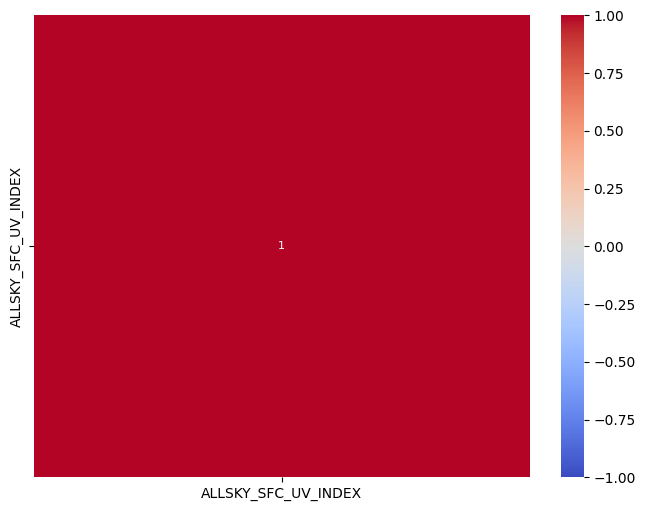

In [9]:
## Heat Map Correlation Tables

plt.figure(figsize=(8, 6))

heatmap = sns.heatmap(
    data_cleaning.corr().abs(),
    annot=True,  # Show correlation values
    annot_kws={'size': 8},  # Reduce annotation font size
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    center=0)